# Doing a measurement on a Qubit through a cavity
This notebook will show how a measurement is made on a qubit trough a signal sent through the cavity.
Depending on the state of the qubit the cavity's resonance frequency will change a small amount and the output of this signal we sent to the cavity will change. This is explained by the Hamiltonian of the interaction. In the dispersive regime we can approximate the Hamiltonian to:

$\displaystyle H = \omega_r a^\dagger a - \frac{1}{2}\omega_q \sigma_z + \chi (a^\dagger a  + 1/2) \sigma_z$

And rearrange it to:

$\displaystyle H =  a^\dagger a (\omega_r+\chi\sigma_z) - \frac{1}{2}\omega_q \sigma_z + \chi (1/2) \sigma_z$


Where $\chi = g^2/\Delta$ and $\Delta=|wc-w1|$. We can get from this an intuition that the state of the qubit expressed by $\sigma_z$ will change the angular frequency  $(\omega_r+\chi\sigma_z)$ of the cavity (by plus or minus $\chi$) and we will measure a different amount of photons depending on the state of the qubit. Following the principles of quantum mechanics this will of course colapse the qubit's wave function to the measured value.

For the simulation we use a Jaynes-Cumming Hamiltonian modified to have a drive in the cavity:

$H = \hbar \omega_r a^\dagger a + A \cos(\omega_dt  + \phi_0) (a + a^\dagger)-\frac{1}{2}\hbar\omega_c\sigma_z+g(a^\dagger+a)(\sigma_-+\sigma_+)$

Where $ A \cos(\omega_dt  + \phi_0)$ is the drive in the cavity.Rewritten as:

$H = \hbar \omega_r a^\dagger a + (A e^{-i\omega_dt}+A^* e^{+i\omega_dt})  (a + a^\dagger)-\frac{1}{2}\hbar\omega_c\sigma_z+g(a^\dagger+a)(\sigma_-+\sigma_+)$

Then we use a unitary transformation at the Hamiltonian:

$U=exp(i\omega_d a^\dagger a t)$

And the rotating wave approximation to elimitate fast rotating terms getting the hamiltonian used:

$H=(\omega_c-\omega)a^\dagger a + A (a+a^\dagger)-\frac{1}{2}(\omega_q-\omega)\sigma_z+g(a^\dagger+a)(\sigma_-+\sigma_+)$

Where $\omega=g^2/|\omega_c-\omega_d|$

This process for a single cavity can be seen with more details at:

https://nbviewer.org/github/jrjohansson/sympsi-notebooks/blob/master/lecture-sympsi-resonator.ipynb

In [1]:
%matplotlib inline

from qutip import *
from math import *

import matplotlib.pyplot as plt
import numpy as np


In [2]:
N = 10

wc = 4.5 * 2 * pi #cavity angular freq
w1 = 4 * 2 * pi #qubit 1 angular freq


g1 = 0.1 * 2 * pi

Omega1=4

chi=g1**2/abs(wc-w1)

tlist = np.linspace(0, 20, 1600)

width = 0.5

#rotating wave approximation
use_rwa= False

In [3]:
w=chi
w

0.1256637061435917

In [4]:
# cavity operators
a = tensor(destroy(N), qeye(2))
n = a.dag() * a

# operators for qubit 1
sm1 = tensor(qeye(N), destroy(2))
sz1 = tensor(qeye(N), sigmaz())
sy1 = tensor(qeye(N), sigmay())
sx1 = tensor(qeye(N), sigmax())
n1 = sm1.dag() * sm1


In [5]:
# Hamiltonian using QuTiP
#cavity
Hc = a.dag() * a * (wc-w)
#qubits
H1 = - 0.5 * sz1 * (w1-w)

#cavity drive
Hdc = (a.dag() + a )

#2*sx
#s+=[[0,1],[0,0]]
#s-=s+.dag()

#qubit drive
Hd1=Omega1*sy1


#Cavity-qubit coupling hamiltonians
# Hamiltonian
if use_rwa:
    Hc1 = g1 * (a.dag() * sm1 + a * sm1.dag())
else:
    Hc1 = g1 * (a.dag() + a) * (sm1 + sm1.dag()) 

In [6]:
#unitary step function
def u_t(t):
    return 1*(t > 0)

In [7]:
#qubit 1 drive
#A = (1/3)*0.0002# field aplitude
def A_t(t, args=None):
    TA1=1
    T_As=10
    Amp=1
    return Amp*(u_t(t-TA1)-u_t(t-TA1-T_As)) 
#+ Amp*(u_t(t-TA2)-u_t(t-TA2-T_As)))

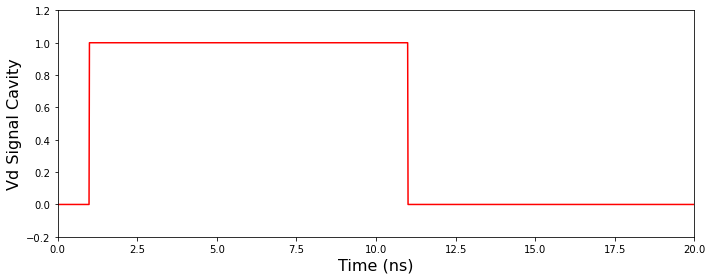

In [28]:
fig, axes = plt.subplots(1, 1, figsize=(10,4))

axes.plot(tlist, [A_t(t) for t in tlist], 'r', label="drive cavity")
axes.set_ylim(-0.2,1.2)
axes.set_xlim(0,20)
axes.set_xlabel("Time (ns)", fontsize=16)
axes.set_ylabel("Vd Signal Cavity", fontsize=16)



fig.tight_layout()

In [29]:
# method 2: a function callback that returns the coefficient for a qobj
    #H = [H0, [H1, lambda x,y: x]]
    #output = mesolve(H, psi0, tlist, c_op_list, [sm.dag() * sm], {})  

#This will multiply Hd1 and Hd2 by the time dependant step functions like wd1_t during the mesolve step
H_t = [[Hdc,A_t], Hc+H1+Hc1]
# initial state: start with two qubits in ground state
psi0 = tensor(basis(N,0),basis(2,0))
psi1 = tensor(basis(N,0),basis(2,1))
res0 = mesolve(H_t, psi0, tlist, [], [])
res1 = mesolve(H_t, psi1, tlist, [], [])

Then we graph the expected value of the operator $a$ which is the photon output of the cavity and the value we would measure coming reflected from it in a real situation.

In [30]:
 def single_qubit_graph(res1, res0):
    fig, axes = plt.subplots(1, 1, sharex=True, figsize=(10,4))

    #axes.plot(tlist, np.real(expect(n1, res.states)), 'b', linewidth=2, label="qubit 1")
    #axes.plot(tlist, np.abs(expect(n, res.states)), 'r', linewidth=2, label="cavity")
    axes.plot(tlist, np.abs(expect(a, res1.states)), 'b', linewidth=2, label="qubit in |1>")
    axes.plot(tlist, np.abs(expect(a, res0.states)), 'r', linewidth=2, label="qubit in |0>")
   #
    #axes.plot(tlist, np.imag(expect(a, res.states)), 'g', linewidth=2, label="cavity")
   # axes.set_ylim(0, 1.5)
    #axes.set_xlim(1,10)

    axes.set_xlabel("Time (ns)", fontsize=16)
    axes.set_ylabel("Expected value of a", fontsize=16)
    axes.legend()

    fig.tight_layout()

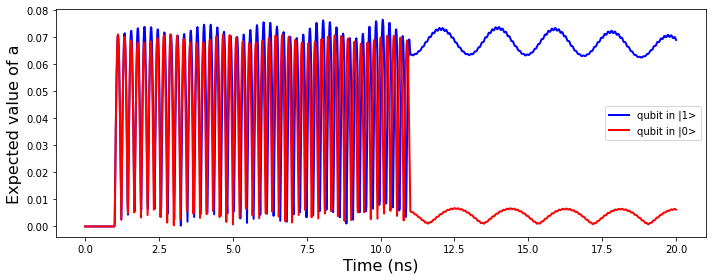

In [31]:
single_qubit_graph(res1, res0)

Then we make the discret fourier transform during the interval we applied A and compare the wave frequencies with each qubit state:

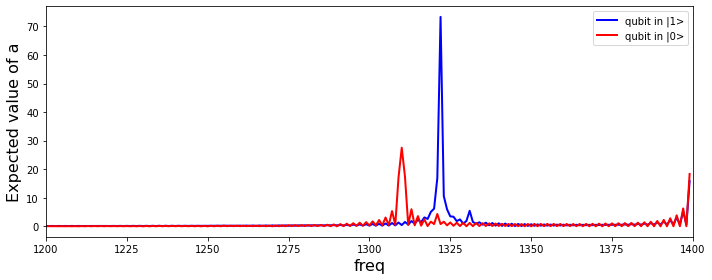

In [34]:

fig, axes = plt.subplots(1, 1, sharex=True, figsize=(10,4))

axes.plot( np.abs(np.fft.fft(expect(a, res1.states)[200:])), 'b', linewidth=2, label="qubit in |1>")
axes.plot( np.abs(np.fft.fft(expect(a, res0.states))[200:]), 'r', linewidth=2, label="qubit in |0>")
#axes.plot(tlist, np.imag(expect(a, res.states)), 'g', linewidth=2, label="cavity")
# axes.set_ylim(0, 1.5)
axes.set_xlim(1200,1400)

axes.set_xlabel("freq", fontsize=16)
axes.set_ylabel("Expected value of a", fontsize=16)
axes.legend()

fig.tight_layout()


And we notice here how the peak frequency for the qubit in the fourier graph is slightly higher for the qubit in the $|1\rangle$ state than for the qubit in the $|0\rangle$ state like expected. Measuring the qubit would ammount to detecting this difference.